# Домашнее задание №7: деревья, случайный лес (14.5 баллов)
<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [1]:
import math

In [9]:
ans = -1 * (8/10 * math.log(8/10) + 2/10 * math.log(2/10))  # энтропия
print(f'{ans:.2}')

0.5


#### (*・‿・)ノ⌒*:･ﾟ✧

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

gini_index = (1.0 - sum(proportion * proportion)) * (group_size/total_samples)

In [19]:
h = 1 - (8/10)**2 - (2/10)**2  # индекс Джини родительской вершины
h_r = 1 - (2/2)**2  # индекс Джини правой вершины
h_l = 1 - (8/8)**2 # индекс Джини левой вершины
final_h = h - 2/10 * h_r - 8/10 * h_l  # критерий информативности
print(f'{final_h:.2}')

0.32


#### (￣▽￣)/♫•*¨*•.¸¸♪

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [12]:
# считается как среднее по ответам всех попавших в вершину объектов
print(sum([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]) / 10)

40.6


#### ༼ つ ◕_◕ ༽つ

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [3]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [180]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

In [188]:
#def r_var(y, mean):
#    return y - mean


def h_cat_class(y):
    def r_cat(el):
        return y[y == el].size
    
    r_cat_ = np.vectorize(r_cat)
    return 1 - np.sum((r_cat_(np.unique(y)) / y.size)**2)


def h_cat_regr(y):
    def r_var(y):
        return y - mean
    mean = np.mean(y)
    r_var_ = np.vectorize(r_var)
    return np.sum(r_var_(y)**2) / y.size

In [229]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    
    # для одного действительного признака
    def real_result(cat):
        # делим таргет на две части
        # необходимо посчитать только отношения размеров классов, поэтому порядок не важен
        y_lower = target_vector[feature_vector < cat]  # все, что ниже порога
        y_higher = target_vector[feature_vector > cat]  # все, что выше порога
        
        # если задача классификации - считаем Джини
        if task == "classification":
            h_lower = h_cat_class(y_lower) * y_lower.size / target_vector.size  # Джини "нижней" части на долю
            h_higher = h_cat_class(y_higher) * y_higher.size / target_vector.size  # Джини "верхней" части на долю
        # если задача регрессии - считаем дисперсию
        elif task == "regression":
            h_lower = h_cat_regr(y_lower) * y_lower.size / target_vector.size  # дисперсия "нижней" части на долю
            h_higher = h_cat_regr(y_higher) * y_higher.size / target_vector.size  # дисперсия "верхней" части на долю
        # получившийся Джини
        q_r = - h_lower - h_higher
        return cat, q_r
    
    # для одного категориального признака
    def cat_result(cat):
        # делим таргет на две части: соответствует категории и не соответствует
        y_cat = target_vector[feature_vector == cat]  # соответствует
        y_not_cat = target_vector[feature_vector != cat]  # не соответствует
        
        # для классификации считаем Джини в обоих частях
        if task == "classification":
            h_cat = h_cat_class(y_cat) * y_cat.size / target_vector.size
            h_not_cat = h_cat_class(y_not_cat) * y_not_cat.size / target_vector.size
        # для регрессии считаем дисперсию обоих частей
        elif task == "regression":
            h_cat = h_cat_regr(y_cat) * y_cat.size / target_vector.size
            h_not_cat = h_cat_regr(y_not_cat) * y_not_cat.size / target_vector.size
        # получившийся Джини
        q_r = - h_cat - h_not_cat
        return cat, q_r
    
    
    # для категориальных признаков
    if feature_type == "categorical":
        cats = np.sort(np.unique(feature_vector))  # выделяем уникальные категории
        # защита от ситуации, когда значения признака на всех объектах одинаковы
        if cats.size == 1:
            return tuple([None, None, None, -float('inf')])
        cat_results = np.vectorize(cat_result)  # векторизируем функцию выше
        result = cat_results(cats)  # запускаем ее от всех уникальных категорий
    # для действиетльных признаков
    elif feature_type == "real":
        """Выделяем уникальные значения признака (чтобы случайно не повториться) и сортируем их для удобства.
        Пороги выделяются следующим образом: *|*|*|*|*|*, ровно посередине между значениями признака,
        где звездочки - значения признака, а вертикальные линии - пороги.
        Это необходимо, чтобы не получался вектор таргета длины ноль (и сортировка была нужна именно для этого)."""
        cats = (np.sort(np.unique(feature_vector))[:-1] + np.sort(np.unique(feature_vector))[1:]) / 2
        # защита от ситуации, когда значения признака на всех объектах одинаковы
        if cats.size == 0:
            return tuple([None, None, None, -float('inf')])
        real_results = np.vectorize(real_result)  # функцию для одного разбиения векторизируем
        result = real_results(cats)  # в результате получаем вектор значений порогов и вектор значений джини для этих порогов

    return tuple([result[0], result[1], result[0][np.argmax(result[1])], np.max(result[1])])

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

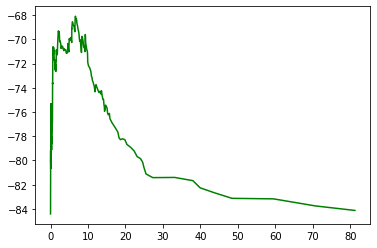

In [183]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
plt.plot(thresholds, variances, 'g')

Поскольку ошибку в данной задаче необходимо максимизировать, то есть как можно сильнее приблизить нулю, нас интересуют самые высокие пики на графике. Наилучшего своего значения ошибка достигает при пороге, приблизительно равном 6.8 - на графике отчетливо виден пик

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [267]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        # есть ли какие-то типы признаков, которые не действительные и не категориальные
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,  # дерево
        sub_X: np.ndarray,  # объекты в вершине
        sub_y: np.ndarray,  # ответы на объекты
        node: dict  # вершина дерева
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):  # если все ответы в вершине одинаковые
            node["type"] = "terminal"  # обозначим листом
            node["class"] = sub_y[0]  # выдадим класс и покинем метод
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):  # счетчик признаков
            feature_type = self._feature_types[feature]  # выбрали признак
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            # если лучший признак не установлен или этот признак лучше установленного, то меняем лучший на этот
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:  # выделяем лист
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node["type"] == "terminal":
            return node['class']
        
        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature] == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [127]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
data = pd.read_csv("/Users/katyona/Desktop/University/proga/iad/notebooks/students.csv")
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [141]:
stu_X = data.drop(data.columns[-1], 1)
stu_y = data[data.columns[-1]]

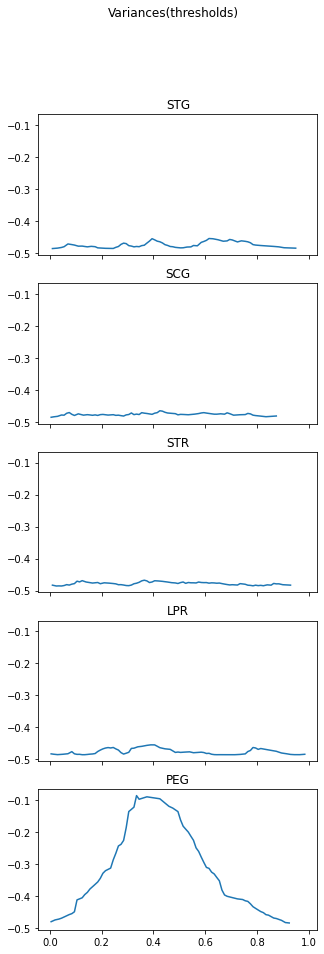

In [140]:
count = 0

fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(5,15))
fig.suptitle('Variances(thresholds)')

for el in stu_X.columns:
    thresholds, variances, _, _ = find_best_split(
        stu_X[el].to_numpy(), 
        stu_y, 
        task="classification",
        feature_type="real"
    )
    axs[count].plot(thresholds, variances)
    axs[count].set_title(f'{el}')
    count += 1

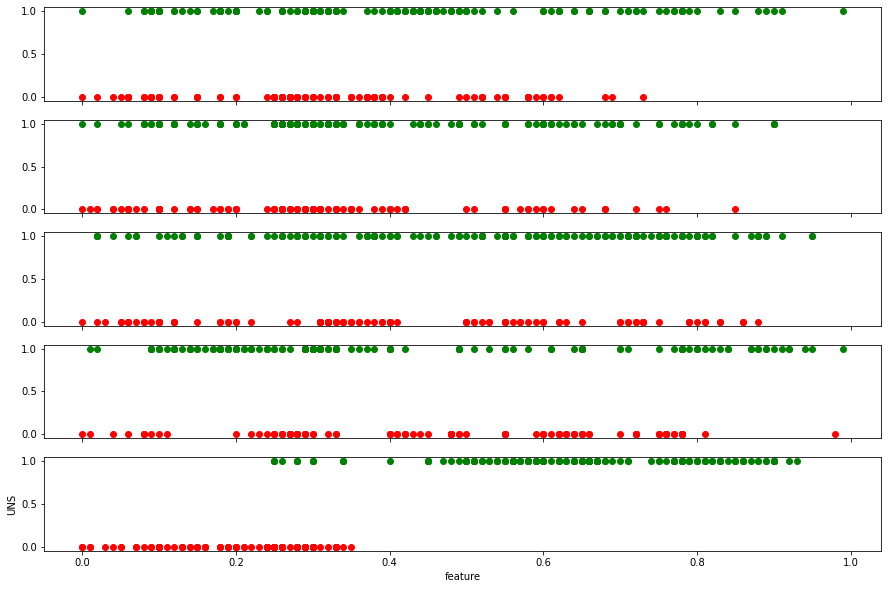

In [150]:
fig, ax = plt.subplots(5, figsize=(15, 10), sharex=True, sharey=True)
data0 = data[data[' UNS'] == 0]
data1 = data[data[' UNS'] == 1]

count = 0
for el in stu_X.columns:
    ax[count].scatter(data1[el], data1[' UNS'], color='green', label='UNS = 1')
    ax[count].scatter(data0[el], data0[' UNS'], color='red', label='UNS = 0')
    plt.xlabel('feature')
    plt.ylabel('UNS')
    count += 1

plt.show()

In [152]:
thresholds, variances, tbest, vbest = find_best_split(
    np.array([1, 2, 3]), 
    np.array([1, 1, 1]), 
    task="classification",
    feature_type="real"
)
print(vbest)

-0.0


### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

1) Наилучший результат ошибки из кривых значений критерия Джини показывает признак PEG.

2) Этот результат отлично согласуется с визуальной оценкой scatter-графиков: на последнем из них (то есть на соответствующем последнему признаку - PEG) видно, что значения признака менее 0.4 дают с наибольшей вероятностью значение целевой переменной, равное 0, а более 0.4 - со стопроцентной вероятностью выдает значение UNS, равное 1.

3) Вид кривой "хороших" признаков - выпуклая кривая, вплотную подходящая к нулю снизу, с пиком в одном из значений. Это будет говорить о том, что признак имеет лучший порог для разбиения, и такой порог обеспечивает максимизацию результатов ошибки, то есть обеспечивает практически ровное разбиение выборки на две части.

4) У признаков, по которым деление практически невозможно, всегда примерно одинаковое значение ошибки - кривая похожа на горизонтальную прямую. Отсутствие четко выраженного пика говорит о том, что у данного признака не существует такого порога, который обеспечивал бы "хорошее" разделение выборки по значению таргета, а значит, и максимизацию значений критерия Джини.

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [198]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
data = pd.read_csv("/Users/katyona/Desktop/University/proga/iad/notebooks/mushrooms.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [185]:
# меняем буквенные обозначения категорий на целочисленные
from sklearn import preprocessing
for i in range(23):
    le = preprocessing.LabelEncoder()
    le.fit(data[i])
    data[i] = le.transform(data[i])

In [186]:
from sklearn.model_selection import train_test_split

# делим выборку объекты и ответы
X = data.drop([0], axis=1)
y = data[0]

# разделяем выброку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

In [268]:
# creating the tree and fitting data to it
dt = DecisionTree(feature_types = ['categorical']*22, max_depth = None, 
                  min_samples_split = None, min_samples_leaf = None, task = "classification")
dt.fit(X.to_numpy(), y.to_numpy())

In [270]:
# построим предсказание по тестовой выборке
y_predicted = dt.predict(X_test.to_numpy())

Вычислим accuracy:

In [271]:
y_test = y_test.to_numpy()
accuracy = y_predicted[y_predicted == y_test].size / y_test.size
accuracy

1.0

## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [1]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [4]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

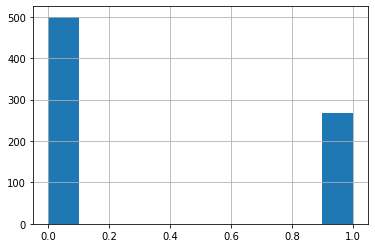

In [5]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [6]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
from sklearn.model_selection import train_test_split

# делим выборку объекты и ответы
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

In [7]:
# разделяем выброку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [15]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-\
clf = BaggingClassifier(n_estimators=50, random_state=11).fit(X_train, y_train)

In [16]:
predict = clf.predict(X_test)

In [17]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predict)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predict)))
print('Recall score: {:.4f}'.format(recall_score(y_test, predict)))
print('Auc-roc score: {:.4f}'.format(roc_auc_score(y_test, predict)))

Accuracy score: 0.7619
Precision score: 0.6410
Recall score: 0.6494
Auc-roc score: 0.7338


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [18]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
clf = RandomForestClassifier(n_estimators=50, random_state=11).fit(X_train, y_train)

In [19]:
predict = clf.predict(X_test)

In [20]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predict)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predict)))
print('Recall score: {:.4f}'.format(recall_score(y_test, predict)))
print('Auc-roc score: {:.4f}'.format(roc_auc_score(y_test, predict)))

Accuracy score: 0.7532
Precision score: 0.6351
Recall score: 0.6104
Auc-roc score: 0.7175


Все показатели качества модели примерно одинаковые, но при этом Bagging Classifier показал результаты чуть лучше по всем показателям

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [56]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
ests = []
scores = []
for i in range(11):
    scores.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
leaves = []
for i in range(0, 10 + 1):
    num_est = 10 + 149 * i
    for j in range(0, 10 + 1):
        leaf = 5 + 11 * j
        clf = RandomForestClassifier(n_estimators=num_est, min_samples_leaf=leaf, 
                                     random_state=110).fit(X_train, y_train)
        predict = clf.predict(X_test)
        score = roc_auc_score(y_test, predict)
        if i == 0:
            leaves.append(leaf)
        scores[i][j] = score
    ests.append(num_est)
ests = np.array(ests)
leaves = np.array(leaves)

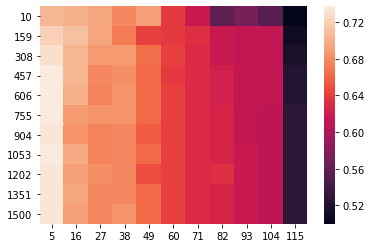

In [62]:
import seaborn as sns

ax = sns.heatmap(scores, xticklabels=leaves, yticklabels=ests)

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [69]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
scores = np.array(scores)
# найдем лучшую модель случайного леса - где результат auc_roc максимальный
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
estimates = ests[ind[0]]
n_leaves = leaves[ind[1]]

In [72]:
clf = RandomForestClassifier(n_estimators=estimates, min_samples_leaf=n_leaves, 
                             random_state=110).fit(X_train, y_train)

In [73]:
importances = clf.feature_importances_

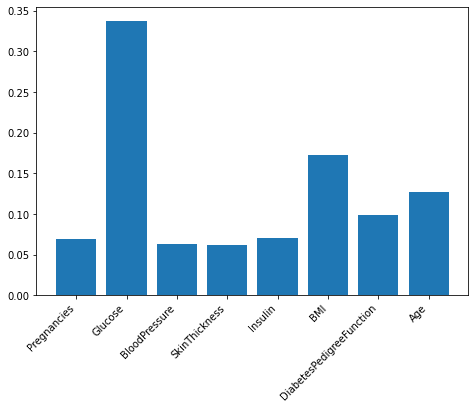

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X.columns, importances)
plt.xticks(rotation=45, horizontalalignment="right")
plt.show()

Самым важным для определения диабета оказался признак Glucose